## Maintenance contract
We will now try to propose a maintenance contract that will allow us to update our model according to the new data.

To do this, we will observe the performance of our model over time depending on its update frequency (monthly, quarterly, semi-annually or annually)

## Initialisation

In [1]:
%matplotlib inline
import pandas as pd
from sklearn import preprocessing
from sklearn import cluster,metrics


# Maintenance

## Recovery of the original data

In [3]:
dfCustomers = pd.read_csv("../data/raw/olist_customers_dataset.csv", sep=",")
dfOrders = pd.read_csv(
    "../data/raw/olist_orders_dataset.csv", sep=",",
    parse_dates=['order_purchase_timestamp']
    )  # puts the variable in "Timestamp" format
dfOrderPay = pd.read_csv(
    "../data/raw/olist_order_payments_dataset.csv", sep=",")
dfOrdReview = pd.read_csv(
    "../data/raw/olist_order_reviews_dataset.csv", sep=",")

# Save the most recent date,
# in order to obtain the delta of the order date, for the Rescence
tsLast = dfOrders.order_purchase_timestamp.max()

df = dfCustomers[['customer_unique_id', 'customer_id']]
df = df.merge(
    dfOrders[['customer_id', 'order_id',
              'order_purchase_timestamp']],
    how='left', on='customer_id')
df = df.merge(dfOrderPay[['order_id',
                          'payment_value']], how='left', on='order_id')

df = df.merge(dfOrdReview[['order_id',
                           'review_score']], how='left', on='order_id')


In [2]:
def mkDfCustomers(df):
    '''
    Constitution of the customer dataframe

        Parameters:
            df (DataFrame): dataframe from the merges
                            of the different useful tables

        Returns:
            dfCustomers (DataFrame): client dataframe
    '''
    df2Features = df.groupby('customer_unique_id')['customer_id']\
        .agg('nunique').reset_index()

    dfCustomers = pd.DataFrame(
        {
            'customer_unique_id': df2Features['customer_unique_id'],
            'freq': df2Features['customer_id'],
            'recen': df.groupby('customer_unique_id')
            ['order_purchase_timestamp']
            .agg('max').apply(lambda x: (tsLast-x).days).values,
            'MSum': df.groupby('customer_unique_id')['payment_value']
            .agg('sum').values,  # order total per customer
            'scrRev': df.groupby('customer_unique_id')['review_score']
            .agg('median').values  # median per customer
        }
    )
    # 716 NaN that I will fill with "-1".
    dfCustomers.loc[dfCustomers.scrRev.isna(), 'scrRev'] = -1

    return dfCustomers


In [4]:
def trsInit(x):
    '''
    Data transformation procedure for training a new model or its update

        Parameters:
            x (DataFrame): Data to be transformed

        Returns:
            x_trans (ndarray): transformed input data
            trsQtl (QuantileTransformer): transformer fitted
            trsStd (StandardScaler): transformer fitted
    '''
    trsQtl = preprocessing.QuantileTransformer(output_distribution='normal',
                                               random_state=0).fit(x[['freq']])
    x.loc[:, 'freq'] = trsQtl.transform(x[['freq']])

    trsStd = preprocessing.StandardScaler().fit(x)
    x_trans = trsStd.transform(x)

    return x_trans, trsQtl, trsStd


In [5]:
def trsPred(x, trsQtl, trsStd):
    '''
    Data transformation procedure for prediction

        Parameters:
            x (DataFrame): data to be transformed
            trsQtl (QuantileTransformer): transformer fitted
            trsStd (StandardScaler): transformer fitted

        Returns:
            x_trans (ndarray): transformed input data
    '''
    x.loc[:, 'freq'] = trsQtl.transform(x[['freq']])
    x_trans = trsStd.transform(x)

    return x_trans


In [6]:
def getMaintenance(df):
    '''
    procedure for providing data to select a maintenance period
    10 day increment loop, over 8 months

        Parameters:
            df (DataFrame): original df without the aggregated varaiables

        Returns:
            lARI (list): list of ARI indices, calculated
    '''
    # init: Set the number of days per loop and the amount of loops
    lARI = []
    nbDaysPeriod = 30 # per month
    nbLoop = 12 # One year

    minDat = df.order_purchase_timestamp.min()
    initialPeriod = minDat + pd.DateOffset(months=16)
    addPeriod = initialPeriod
    dfPeriod = df.loc[df['order_purchase_timestamp'] < initialPeriod, :]
    dfCustomers = mkDfCustomers(dfPeriod)

    dfX = dfCustomers[['freq', 'recen', 'MSum', 'scrRev']]
    # initial transformation and recovery of transformers Initial estimator
    x_trans, trsQtlInit, trsStdInit = trsInit(dfX)

    # initial estimator
    clsInit = cluster.KMeans(
        n_clusters=4,
        random_state=0)
    ModlInit = clsInit.fit(x_trans)

    for i in range(nbLoop):
        print(f"Loop no.: {i} ")
        addPeriod += pd.DateOffset(days=nbDaysPeriod)
        print(f"Offset: {addPeriod} ")

        dfPeriod = df.loc[df['order_purchase_timestamp'] < addPeriod, :]
        dfCustomers = mkDfCustomers(dfPeriod)

        dfX = dfCustomers[['freq', 'recen', 'MSum', 'scrRev']]

        # prediction of the initial model with the initial transform
        x_trans = trsPred(dfX, trsQtlInit, trsStdInit)
        pred = ModlInit.predict(x_trans)

        # transformer update
        x_trsUpdt, trsQtl, trsStd = trsInit(dfX)

        # update of the estimator
        clsMaj = cluster.KMeans(
            n_clusters=4,
            random_state=0)
        ModlMaj = clsMaj.fit(x_trsUpdt)

        # calculation of the ARI
        ari = metrics.adjusted_rand_score(ModlMaj.labels_, pred)
        print(f"ARI value: {ari} ")
        lARI.append(ari)

        print("*******************")

    return lARI


In [7]:
lAri = getMaintenance(df)


C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


Loop no.: 0 
Offset: 2018-02-03 21:15:19 


C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


ARI value: 0.8481223738100376 
*******************
Loop no.: 1 
Offset: 2018-03-05 21:15:19 


C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


ARI value: 0.7786012343986217 
*******************
Loop no.: 2 
Offset: 2018-04-04 21:15:19 


C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


ARI value: 0.7247145934435636 
*******************
Loop no.: 3 
Offset: 2018-05-04 21:15:19 


C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


ARI value: 0.6837466095839703 
*******************
Loop no.: 4 
Offset: 2018-06-03 21:15:19 


C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


ARI value: 0.6444479384157336 
*******************
Loop no.: 5 
Offset: 2018-07-03 21:15:19 


C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


ARI value: 0.5919203936676442 
*******************
Loop no.: 6 
Offset: 2018-08-02 21:15:19 


C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


ARI value: 0.5593076182560598 
*******************
Loop no.: 7 
Offset: 2018-09-01 21:15:19 


C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


ARI value: 0.44919871815664275 
*******************
Loop no.: 8 
Offset: 2018-10-01 21:15:19 


C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


ARI value: 0.44753606323753703 
*******************
Loop no.: 9 
Offset: 2018-10-31 21:15:19 


C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


ARI value: 0.45019327819781685 
*******************
Loop no.: 10 
Offset: 2018-11-30 21:15:19 


C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


ARI value: 0.45019327819781685 
*******************
Loop no.: 11 
Offset: 2018-12-30 21:15:19 


C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\ezequ\miniconda3\envs\olist\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


ARI value: 0.45019327819781685 
*******************


Text(0, 0.5, 'ARI')

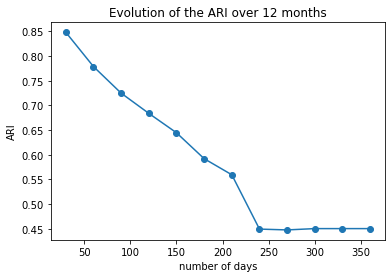

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(30, 390, 30), lAri, marker='o')
plt.title("Evolution of the ARI over 12 months")
plt.xlabel("number of days")
plt.ylabel("ARI")


We observe that the ARI goes down dramatically around 210 days, meaning we should propose a maintenance contract every 6 to 7 seven months. 